In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import ceil
from scipy.stats import kstest, f_oneway

In [2]:
RESULTS = 'results/'
PLOTS = f'{RESULTS}plots/'
REPORTS = f'{RESULTS}reports'
BFE = f'{RESULTS}best_fitness_execution/'

In [3]:
parametricos = pd.read_csv(f"{BFE}best_fit_per_config_parametric.csv")
resultados = pd.read_csv(f"{RESULTS}resultados.csv")

In [6]:
def normality_test(sample): 
        standarized_sample = (sample - np.mean(sample)) / np.std(sample, ddof=1)
        return kstest(standarized_sample, "norm", alternative='two-sided').pvalue

def anova_test(samples):
        return f_oneway(*samples).pvalue

In [11]:
def print_hist_plots(df, plot_name):
    fig, axs = plt.subplots(ceil(len(df.columns)/2), 2, figsize=(20, 20))
    for col,ax in zip(df.columns, axs.flatten()):
        ax.hist(df[col], density=True)
        ax.set_title(col)
        xlim = ax.get_xlim()
        
        # kernel density estimate
        df[col].plot.density(color='k', alpha=0.5, ax=ax)
        
        ax.set_xlim(xlim)
        ax.legend(labels=['KDE'], frameon=False)
        ax.text(0.98, 0.9, f"p-value={normality_test(df[col]):.5f}", verticalalignment ='top', horizontalalignment ='right', transform = ax.transAxes, color ='black', fontsize = 12)
        
        ax.set_title(col, fontsize=14, pad=15)
        
    fig.savefig(f"{PLOTS}{plot_name}.png")

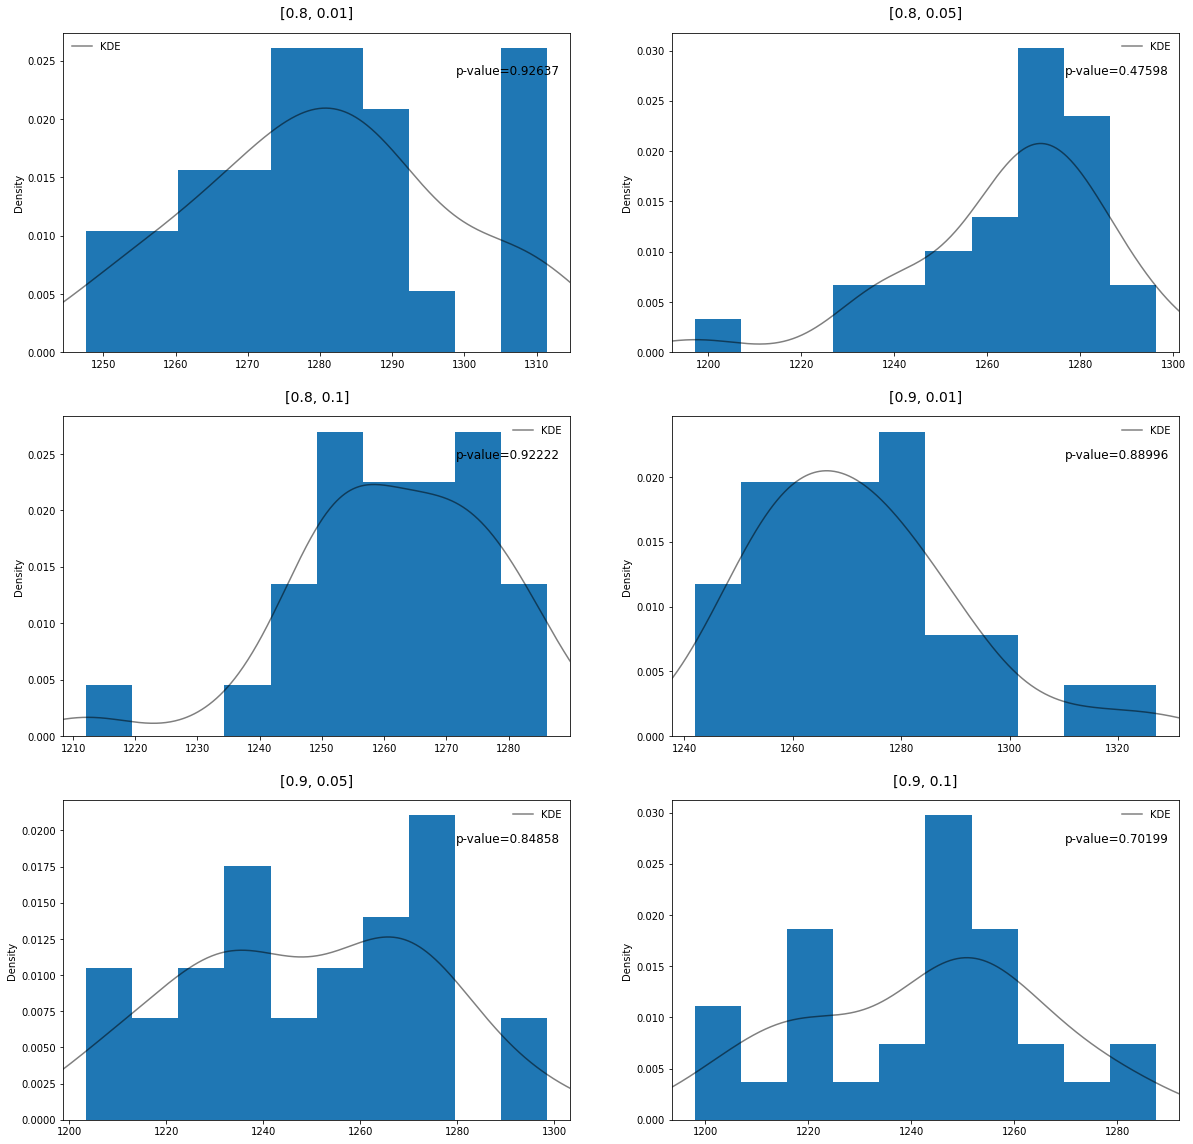

In [12]:
print_hist_plots(parametricos, "parametric")

In [10]:
f_oneway(*[parametricos[col] for col in parametricos.columns])

F_onewayResult(statistic=14.03663642461185, pvalue=1.575577368841589e-11)

The p-value turn out to be 1.5755e-11. <br>
Since the p-value is less than 0.05 hence we would reject the null hypothesis. <br>
This implies that we have sufficient proof to say that there exists a difference in the performance among four different configurations. 

In [4]:
import scikit_posthocs as ph

In [5]:
posthoc = ph.posthoc_nemenyi_friedman(parametricos)
posthoc

,"[0.8, 0.01]","[0.8, 0.05]","[0.8, 0.1]","[0.9, 0.01]","[0.9, 0.05]","[0.9, 0.1]"
"[0.8, 0.01]",1.000000,0.128313,0.002042,0.341681,0.001000,0.001000
"[0.8, 0.05]",0.128313,1.000000,0.751714,0.900000,0.233806,0.004493
"[0.8, 0.1]",0.002042,0.751714,1.000000,0.470741,0.900000,0.203269
"[0.9, 0.01]",0.341681,0.900000,0.470741,1.000000,0.077164,0.001000
"[0.9, 0.05]",0.001000,0.233806,0.900000,0.077164,1.000000,0.711856
"[0.9, 0.1]",0.001000,0.004493,0.203269,0.001000,0.711856,1.000000


The Nemenyi post-hoc test produces the p-values for each pairwise comparison of means. These values are: <br>
    P-value of [0.8, 0.01] vs. [0.8, 0.05] : 0.128313 <br>
    etc. <br>

For α = 0.05 there are only 5 groups that seem to have statistically significantly different means (p-value < 0.05). <br>
* [0.8, 0.01] vs [0.8, 0.1] : 0.002042   <br>
* [0.8, 0.01] vs [0.9, 0.05] : 0.001000 <br>
* [0.8, 0.01] vs [0.9, 0.1] : 0.001000 <br>
* [0.8, 0.05] vs [0.9, 0.1] : 0.004493 <br>
* [0.9, 0.01] vs [0.9, 0.1] : 0.001000 <br>



In [22]:
posthoc[posthoc < 0.05]

,"[0.8, 0.01]","[0.8, 0.05]","[0.8, 0.1]","[0.9, 0.01]","[0.9, 0.05]","[0.9, 0.1]"
"[0.8, 0.01]",NaN,NaN,0.002042,NaN,0.001,0.001000
"[0.8, 0.05]",NaN,NaN,NaN,NaN,NaN,0.004493
"[0.8, 0.1]",0.002042,NaN,NaN,NaN,NaN,NaN
"[0.9, 0.01]",NaN,NaN,NaN,NaN,NaN,0.001000
"[0.9, 0.05]",0.001000,NaN,NaN,NaN,NaN,NaN
"[0.9, 0.1]",0.001000,0.004493,NaN,0.001,NaN,NaN


In [15]:
configs = [ (r,c) for (r,c) in zip(*np.where(posthoc[posthoc < 0.05].notnull())) if r<c ]
configs

[(0, 2), (0, 4), (0, 5), (1, 5), (3, 5)]

https://eva.fing.edu.uy/pluginfile.php/357415/mod_resource/content/1/StatTests.pdf
diapo 21

In [49]:
df = pd.DataFrame({'values': parametricos.values.flatten(),
                   'group': np.tile(parametricos.columns, (1, 30))[0]}) 

In [66]:
for col in parametricos.columns:
    print( np.array_equal(df[df["group"] == col]["values"].values, parametricos[col].values) )

True
True
True
True
True
True


In [67]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# perform multiple pairwise comparison (Tukey HSD)
m_comp = pairwise_tukeyhsd(endog=df["values"], groups=df["group"], alpha=0.05)
print(m_comp)

      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1      group2   meandiff p-adj   lower    upper   reject
----------------------------------------------------------------
[0.8, 0.01] [0.8, 0.05] -15.9054 0.0371 -31.2401  -0.5708   True
[0.8, 0.01]  [0.8, 0.1] -18.8052 0.0068 -34.1399  -3.4706   True
[0.8, 0.01] [0.9, 0.01]  -8.6888  0.578 -24.0235   6.6458  False
[0.8, 0.01] [0.9, 0.05] -31.4542    0.0 -46.7888 -16.1195   True
[0.8, 0.01]  [0.9, 0.1]  -38.022    0.0 -53.3566 -22.6873   True
[0.8, 0.05]  [0.8, 0.1]  -2.8998 0.9942 -18.2345  12.4348  False
[0.8, 0.05] [0.9, 0.01]   7.2166  0.753  -8.1181  22.5512  False
[0.8, 0.05] [0.9, 0.05] -15.5488 0.0448 -30.8834  -0.2141   True
[0.8, 0.05]  [0.9, 0.1] -22.1166 0.0007 -37.4512  -6.7819   True
 [0.8, 0.1] [0.9, 0.01]  10.1164  0.405  -5.2183   25.451  False
 [0.8, 0.1] [0.9, 0.05]  -12.649 0.1701 -27.9836   2.6857  False
 [0.8, 0.1]  [0.9, 0.1] -19.2167 0.0053 -34.5514  -3.8821   True
[0.9, 0.01] [0.9, 0.05] -

https://www.statology.org/tukey-test-python/

https://eva.fing.edu.uy/pluginfile.php/357415/mod_resource/content/1/StatTests.pdf
diapo 14

dan distintos resultados
ver mañana